# Toxic Comment Classification with Deep Learning

A CTAWG demo with PyTorch fast.ai and Keras. [View the Toxic Comment Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) on Kaggle.

In Colab: Click View -> Table of Contents to show an outline to the left.

Steps:
- Sign up for Kaggle account
- Download data from Kaggle
- Clean data
- Fine-tune language model
- Build classifier
- Generate predictions
- Submit to leaderboard (using Kaggle CLI)


Todo:
- Replace hate speech example prediction text with a hateful comment from the training data (or test).
- Re-run final example text predictions
- Fix manual install of fast.ai module which doesn't persist across workspace restarts in FloydHub
- Fix processed data being saved into the data-raw folder
- Report AUC
- Multi-output model for all 6 outcomes (fast.ai lesson 8/9 in part 2)
- Generate predictions for all models (see bottom of https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline)
- Compare to BERT, GPT-2, standard LSTM/CNN, etc.
- Handle class imbalance (or just ignore?)
- Get working on Benten, home desktop, and XSEDE

## Prepare environment

### Setup Google Colab

Go to Runtime -> Change runtime type and under "Hardware Accelerator" select "GPU".

Or use FloydHub - much faster for actual training, although expensive.

The cell below should print "true" if the GPU is working:

In [ ]:
# Test pytorch GPU access.
import torch
torch.cuda.is_available()

### Setup Kaggle Account and Data

Using https://www.kaggle.com/general/51898 as a guide.

Go to [Kaggle](https://www.kaggle.com)
- Create an acocunt, or login to your existing account
- Click "MyAccount"
- Create "New API Token" button
- This will automatically download a "kaggle.json" file.
- Run the cell below and upload that file:

In [ ]:
# Run this in CoLab; in FloydHub upload via JupyterLab.
# Run this cell, then browse to your downloaded kaggle.json and upload.
from google.colab import files
files.upload()

Setup Kaggle profile. Code via https://www.kaggle.com/general/51898

In [ ]:
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

### Install python packages

In [ ]:
# Install kaggle packages (not needed on floydhub)
# !pip3 install -q kaggle kaggle-cli
# Already installed: pytorch 1.0.1, torchvision, numpy, fast.ai, tensorflow-gpu, keras

In [ ]:
# Install GitHub version of fast.ai
!git clone https://github.com/fastai/fastai
# Run this in a single line because "!cd" does not persist across lines.
# NOTE: on FloydHub I had to run via the terminal due to path issues. TBD.
!cd fastai && tools/run-after-git-clone && pip install -e ".[dev]"

Download the data files for this competition. [See kaggle API documentation](https://github.com/Kaggle/kaggle-api) for more details.

In [ ]:
# Store our kaggle data in the data-raw subdirectory to stay organized.
# Also create a folder for processed data.
!mkdir -p data-raw data

# This will download zipfiles of sample_submission.csv, test.csv, train.csv, test_labels.csv into the current directory
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge -p data-raw

# We need to quote the "*" in order for unzip to work on multiple files.
# -o: overwrite existing files without prompting
# -q: quiet mode
!unzip -oq 'data-raw/*.zip' -d data-raw

# Check the number of lines in each of these new csv files.
!wc -l data-raw/*.csv

## Preprocessing

In [1]:
# This will also import pandas as pd apparently.
# If this fails make sure that fastai is installed from github above.
import fastai
from fastai.text import *
# Should be 1.0.51.dev0, not 1.0.42 (too old)
print(fastai.__version__)

raw_data = Path("data-raw")
data_path = Path("data")

#bs = 8
#bs = 48
#bs = 128 # works on tesla V100 (FloydHub)
bs = 160 # works for LM on tesla V100 (FloydHub)

1.0.51.dev0


In [ ]:
df = pd.read_csv(raw_data / "train.csv")

print(df.head(), "\n"*2)

# Last 6 columns are the outcomes.
outcomes = df.columns[-6:]

# Examine the outcome distribution. Identity hate is only 0.9% positive!
print(df[outcomes].mean(axis = 0), "\n")

# We have only 1,405 positive cases vs. 158,166 negative cases :/
print(df["identity_hate"].value_counts())

In [ ]:
# Take a look at the first comment
print(df["comment_text"][0], "\n")

# And look at some identity_hate rows.
# Trigger warning: this may contain slurs and other offensive language.
print(df[df["identity_hate"] == 1].head(), "\n")

# Look at outcome distribution among the identity hate observations.
print(df[df["identity_hate"] == 1][outcomes].mean(axis = 0))

In [ ]:
# This will take about 3 minutes.
# TODO: also include test.csv for the language model training.
data_lm = (TextList.from_csv(raw_data, 'train.csv', cols = "comment_text")
             # Randomly split and keep 10% for validation of the language model.
             .split_by_rand_pct(0.1)
             .label_for_lm()           
             .databunch(bs = bs))
             
# Type needs to be TextLMDataBunch for use in language model fine-tuning.
print(type(data_lm))

# This will be saved into the data-raw directory unfortunately.
data_lm.save('data_lm.pkl')

In [3]:
# The next time we run this notebook, skip above cell and load the preprocessed data.
# If you get an error "load_data does not exist" then using too old of a fastai module.
data_lm = load_data(raw_data, 'data_lm.pkl', bs=bs)
# This should be a TextLMDataBunch
type(data_lm)

fastai.text.data.TextLMDataBunch

In [ ]:
data_lm.show_batch()

# Examine vocabulary
print(data_lm.vocab.itos[:15])

# 60k tokens in our vocabulary
print(len(data_lm.vocab.itos))

## Language Modeling

In [4]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

# Clear unused GPU memory, to help lr_find().
torch.cuda.empty_cache()

In [ ]:
from fastai.utils.mem import gpu_mem_get
gpu_mem_get()

In [ ]:
# This can give a RuntimeError if the GPU runs out of memory ("CUDA out of memory").
# If this happens we need to use a smaller batch size.
# GPU RAM usage is also affected by other running notebooks in Google Colab.
# (See Runtime -> "Manage sessions" to delete old sessions.)
# This will take about 1 minute.
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=12, skip_start=60)

In [ ]:
# This will take 46 minutes on Google Colab GPU! Accuracy after epoch 0: 21%
# Takes only 7 minutes per epoch on FloydHub Tesla V100, with batch size of 160!
learn.fit_one_cycle(1, 2e-1, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head')

In [ ]:
learn.load("fit_head");

In [ ]:
learn.unfreeze()

# 51 mins per epoch on Colab GPU, 7.5 per epoch on FloydHub v100
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

# 2 mins / X mins
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

In [ ]:
#TEXT = "I liked this movie because"
TEXT = "I hate myself for"
N_WORDS = 30
N_SENTENCES = 4

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:

learn.save_encoder('fine_tuned_enc')

## Classification

In [ ]:
# Following lesson3-imdb from fast.ai course 1
# https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb

# Define our outcome column. Other options shown in the cell output above.
outcome = "identity_hate"

# More documentation at https://docs.fast.ai/text.data.html
# This will take about 2-3 minutes to run.
# Other parameters: max_vocab (default 60k), min_freq (default 2), bs (default 64)
data_clas = TextDataBunch.from_csv(raw_data, 'train.csv', text_cols = "comment_text", \
                              # Max_vocab needs to match the vocabulary size of the LM encoder
                              max_vocab = 60000, \
                             # Reduce vocabulary size due to GPU memory constraints.
                              #max_vocab = 20000, \
                              #max_vocab = 50000, \
                              # Limit batch size due to GPU memory constraints.
                              label_cols = outcome, bs = bs)

# This takes 45 seconds or so.
data_clas.save('data_clas.pkl')

In [5]:
# 160 is too big for FloydHub
data_clas = load_data(raw_data, 'data_clas.pkl', bs= 64)

In [ ]:
data_clas.show_batch()

In [6]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


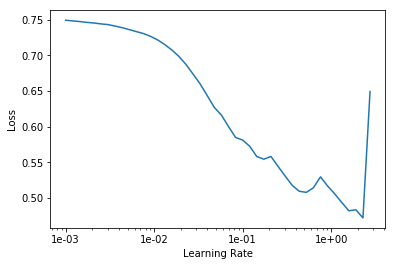

In [14]:
learn.recorder.plot(skip_end=2, skip_start = 50)

In [15]:
# 3.2 mins on FloydHub, 99% accuracy
learn.fit_one_cycle(1, 1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.045117,0.043947,0.990537,03:11


In [16]:
learn.save('first')

In [17]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.032192,0.051000,0.989096,03:46


In [18]:
learn.save('second')

In [19]:
# This is worse :/
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.029615,0.198532,0.989785,06:20


In [ ]:
learn.save('third')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.save('last')

## Prediction

Trigger warning: we need to test some hateful speech in order for this to be a worthwhile exercise.

In [ ]:
print(learn.predict("I hate dirty green people, kill them all!! So vile and disgusting!!! Fuck em"))
# Positive identity speech
print(learn.predict("I am proud to be a brown Mexican immigrant latina"))
# Positive robot speech
print(learn.predict("I am a happy deep learning algorithm"))

In [ ]:
## Score on test
## Generate export

## Submit Kaggle entry (for posterity) using kaggle-cli